In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

- 군집(clustring): 비슷한 샘플을 클러스터로 모음. 군집은 훌륭한 도구임
- 이상치 탐지(outlier detection): 정상 데이터가 어떻게 보이는지 학습 -> 그다음 비정상 샘플을 감지하는 데 사용
- 밀도 추정(density estimation): 데이터셋 생성 확률 과정(random process)의 확률 밀도 함수(pdf, probability density function)를 추정 -> 밀도가 매우 낮은 영역에 놓인 샘플은 이상치일 가능성이 높음. 그리고 데이터 분석과 시각화에도 유용함

### 군집에서 각 샘플의 레이블은 알고리즘이 샘플에 할당한 클러스터 인덱스임 -> 분류에서 클래스 레이블과 헷갈리면 안됨!! -> 군집이 비지도 학습인 것을 잊으면 안됨!!

## 9.1 군집

꽃밭에 여러 종류의 꽃이 있음 -> 꽃의 종류가 뭔지 모름 -> 하지만 비슷한 꽃끼리 모을 수는 있음 -> 이게 군집임 -> 분류랑은 다른 것임!!

### 군집이 사용되는 애플리케이션

- 고객 분류: 고객을 구매 이력이나 웹사이트 내 행동 등을 기반으로 클러스트로 모을 수 있음 -> 고객이 누구인지, 뭘 좋아하는 지 이해하는 데에 도움이 됨 -> 고객 그룹마다 제품 추천이나 마케팅 전략을 다르게 적용할 수 있음 -> 예) 추천 시스템을 만들 수 있음

- 데이터 분석: 새로운 데이터셋을 분석할 때 군집을 나누고 각 군집을 따로 분석하면 도움이 됨

- 차원 축소 기법: 한 데이터셋에 군집 알고리즘을 적용하면 각 군집에 대한 샘플의 친화성(affinity)을 측정할 수 있음(친화성은 샘플이 클러스터에 얼마나 잘 맞는지를 측정) -> 예) k개의 클러스터가 있다면 어떤 샘플의 클러스터 친화성 벡터는 k차원이 됨

- 이상치 탐지: 모든 클러스터에 친화성이 낮은 샘플은 이상치일 가능성이 높음 -> 결함을 감지할 때 유용 -> 예) 제조 결함, 부정 거래 감지 등

- 준지도 학습: 레이블된 샘플이 적다면 군집을 수행하고 동일 클러스터에 있는 모든 샘플에 레이블 전파

- 검색 엔진: 제시된 이미지와 비슷한 이미지를 찾아주는 검색 엔진 -> DB에 있는 모든 이미지를 군집화함 -> 사용자가 찾으려는 이미지를 제공하면 훈련된 군집 모델을 사용해 이미지의 클러스트를 찾아서 반환해줌

- 이미지 분할: 색을 기반으로 픽셀을 클러스터로 모음 -> 그다음 각 픽셀의 색을 해당 클러스터의 평균 색으로 바꿈 -> 이는 이미지에 있는 색상의 종류를 크게 줄임 -> 이렇게 하면 물체의 윤곽을 감지하기 쉬워져 물체 탐지 및 추적 시스템에서 이미지 분할을 많이 활용함

### 9.1.1 k-평균

In [2]:
from sklearn.datasets import make_blobs

In [3]:
blob_centers = np.array(
    [[0.2, 2.3],
     [-1.5, 2.3],
     [-2.8, 1.8],
     [-2.8, 2.8],
     [-2.8, 1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

In [4]:
X, y = make_blobs(n_samples=2000, centers=blob_centers,
                 cluster_std=blob_std, random_state=7)

In [5]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel('$x_1$', fontsize=14)
    plt.ylabel('$x_2$', fontsize=14, rotation=0)

Saving figure blobs_plot


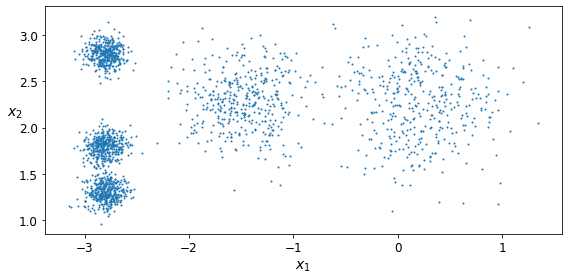

In [6]:
plt.figure(figsize=(8, 4))
plot_clusters(X)
save_fig("blobs_plot")
plt.show()

In [7]:
from sklearn.cluster import KMeans

In [8]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

In [9]:
y_pred

array([4, 0, 1, ..., 2, 1, 0], dtype=int32)

In [10]:
y_pred is kmeans.labels_ # KMeans 클래스의 인스턴스는 labels_ 인스턴스 변수에 훈련된 샘플의 레이블을 가지고 있음

True

In [11]:
# 센트로이드: 각 군집에서 중앙에 있는 값
kmeans.cluster_centers_ # 알고리즘이 찾은 센트로이드 다섯 개

array([[-2.80389616,  1.80117999],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80037642,  1.30082566]])

In [12]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]]) # 새로운 샘플 할당해보기
kmeans.predict(X_new)

array([1, 1, 2, 2], dtype=int32)

#### 보로노이 다이어그램(Voronoi tessellation): 평면을 특정 점까지의 거리가 가장 가까운 점의 집합으로 분할한 그림

In [13]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

Saving figure voronoi_plot


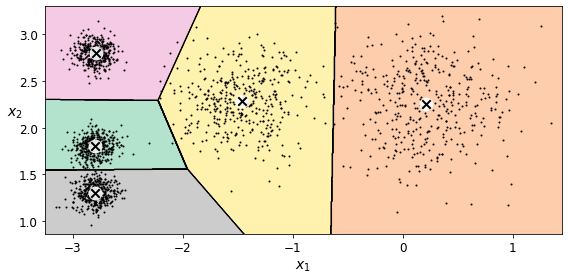

In [14]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
save_fig("voronoi_plot")
plt.show()

위의 그림을 보면 대부분 잘 분할 됨. 하지만 샘플 몇 개(예: 핑크색과 노란색의 경계)는 레이블이 잘못 부여됨 -> k-means 알고리즘은 샘플을 클러스터에 할당할 때 센트로이드까지 거리를 고려하는 것이 전부이기 때문에 클러스터의 크기가 많이 다르면 잘 작동하지 않음

- 하드 군집(hard clustring): 샘플을 오직 하나의 클러스터에 할당
- 소프트 군집: 샘플이 여러 클러스터에 할당될 수 있음(클러스터마다 샘플에 점수를 부여)

In [15]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.transform(X_new)

# [0, 2]와 다섯 개의 센트로이드 사이 거리 = [2.81093633, 0.32995317, 2.9042344 , 1.49439034, 2.88633901]
# 거리가 가장 짧은 군집으로 예측되겠구나

array([[2.81093633, 0.32995317, 2.9042344 , 1.49439034, 2.88633901],
       [5.80730058, 2.80290755, 5.84739223, 4.4759332 , 5.84236351],
       [1.21475352, 3.29399768, 0.29040966, 1.69136631, 1.71086031],
       [0.72581411, 3.21806371, 0.36159148, 1.54808703, 1.21567622]])

#### K-means 알고리즘의 작동 방식

1. 센트로이드를 랜덤하게 선정(예를 들어 무작위로 k개의 샘플을 뽑아 그 위치를 센트로이드로 지정)
2. 샘플에 레이블 할당
3. 센트로이드 업데이터
4. 센트로이드에 변화가 없을 때(수렴)까지 2와 3을 반복

In [16]:
kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=1, random_state=0)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=2, random_state=0)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=3, random_state=0)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

KMeans(algorithm='full', init='random', max_iter=3, n_clusters=5, n_init=1,
       random_state=0)

Saving figure kmeans_algorithm_plot


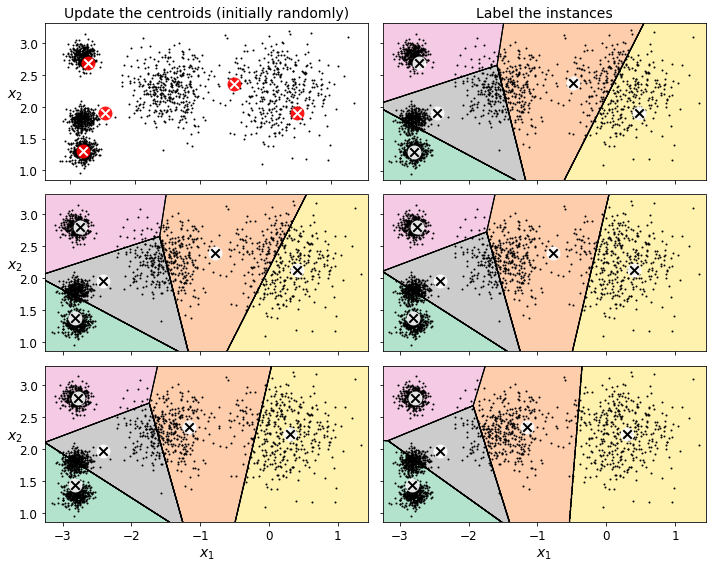

In [17]:
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

save_fig("kmeans_algorithm_plot")
plt.show()

In [18]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

Saving figure kmeans_variability_plot


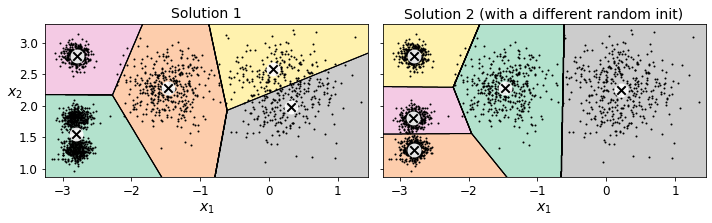

In [19]:
kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=2)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=5)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solution 1", "Solution 2 (with a different random init)")

save_fig("kmeans_variability_plot")
plt.show()

# 아래 그림은 local optimum으로 수렴한 두 경우 -> 센트로이드 초기화때문에

#### 센트로이드 초기화 개선하기

- 센트로이드의 위치를 근사하게 알 수 있다면 (예를 들어 다른 군집 알고리즘을 먼저 실행해서) init 매개변수에 센트로이드 리스트를 담은 넘파이 배열을 지정하고 n_init=1로 설정
- 다른 방법으로는 n_init을 통해 알고리즘을 여러 번 실행하는 것 -> n_init은 서로 다른 센트로이드를 셋팅하는 횟수 -> n_init=10이면 서로 다른 초기 센트로이드 10개로 전체 알고리즘을 실행한 후 가장 좋은 솔루션을 반환
    - 가장 좋은 솔루션은 무슨 기준으로 앎? -> 각 샘플과 가장 가까운 센트로이드 사이의 평균 제곱 거리인 모델의 이너셔(inertia)라는 성능 지표를 이용

In [20]:
kmeans.inertia_

211.59853725816836

In [21]:
kmeans.score(X)
# score()는 inertia의 음숫값을 반환 -> 사이킷런의 '큰 값이 좋은 것이다'라는 규칙을 따르기 위해

-211.59853725816836

#### k-means++ 알고리즘의 똑똑한 초기화 단계: 다른 센트로이드와 거리가 먼 센트로이드를 선택하기

KMeans 클래스는 기본적으로 이러한 방식을 사용. 랜덤하게 선택하는 방식을 사용하고 싶다면 init='random'으로 지정. 하지만 이렇게 할 필요는 거의 없을 것.

### k-means 속도 개선

불필요한 거리 계산을 많이 피함으로써 속도를 높일 수 있음 -> 삼각 부등식 사용
$$AC <= AB + BC$$
-> 두 점 사이의 직선은 항상 최단거리임

-> 샘플과 센트로이드 사이의 거리를 위한 하한선과 상한선을 유지(이 방법은 KMeans 클래스에서 기본으로 사용)

### 미니배치 k-means

mini-batch k-means가 k-means보다 훨씬 빠름

mini-batch k-means의 inertia가 k-means의 inertia보다 나쁨

In [22]:
from sklearn.cluster import MiniBatchKMeans

In [23]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(X)

MiniBatchKMeans(n_clusters=5, random_state=42)

In [24]:
minibatch_kmeans.inertia_

211.652398504332

### 최적의 클러스터 개수 찾기

k(클러스터 개수)가 증가할수록 inertia는 작아짐 -> inertia가 작은 k를 선택하는 것은 안됨

Saving figure bad_n_clusters_plot


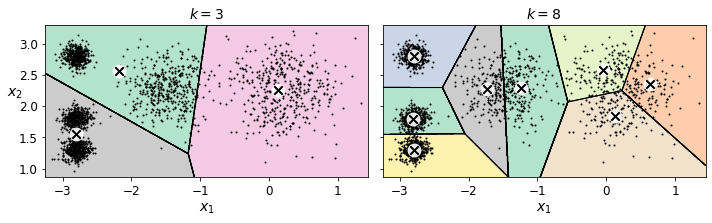

In [25]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
save_fig("bad_n_clusters_plot")
plt.show()

In [26]:
kmeans_k3.inertia_

653.2167190021553

In [27]:
kmeans_k8.inertia_ # k=5일 때 inertia = 211.6

119.11983416102879

In [28]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

Saving figure inertia_vs_k_plot


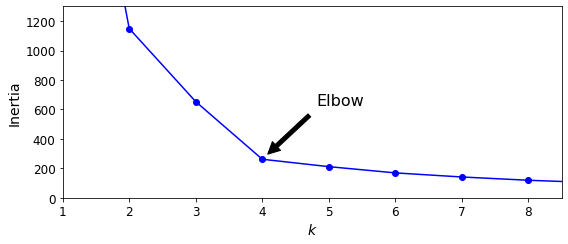

In [29]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
save_fig("inertia_vs_k_plot")
plt.show()

inertia가 k=4일 때 꺾임(Elbow) -> 따라서 k에 대해 모른다면 k=4는 좋은 선택일 것임 -> 하지만 이 방법은 너무 엉성함

#### 실루엣 점수(silhouette score): 위 방법보다 계산 비용은 많이 들지만 더 정확한 방법. 이 값은 모든 샘플에 대한 실루엣 계수의 평균
$$ \frac{(b-a)}{max(a, b)} $$
- a: 동일한 클러스터에 있는 다른 샘플까지 평균 거리(즉 클러스터 내부의 평균 거리)
- b: 가장 가까운 클러스터까지 평균 거리(즉 가장 가까운 클러스터의 샘플까지 평균 거리)
- $a << b$ -> 1에 가까움 -> 자신의 클러스터 안에 잘 속해 있고 다른 클러스터와는 멀리 떨어져 있다는 뜻
- $a >> b$ -> -1에 가까움 -> 이 샘플이 잘못된 클러스터에 할당되었다는 의미

In [30]:
from sklearn.metrics import silhouette_score

In [31]:
silhouette_score(X, kmeans.labels_)

0.655517642572828

In [32]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

Saving figure silhouette_score_vs_k_plot


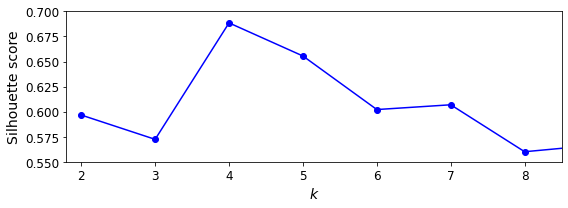

In [33]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
save_fig("silhouette_score_vs_k_plot")
plt.show()

# 클러스터 개수(k)를 달리하여 실루엣 점수를 비교 -> 이렇게 비교하니 inertia를 비교했을 때는 보이지 않는 것이 보임

#### 실루엣 다이어그램

Saving figure silhouette_analysis_plot


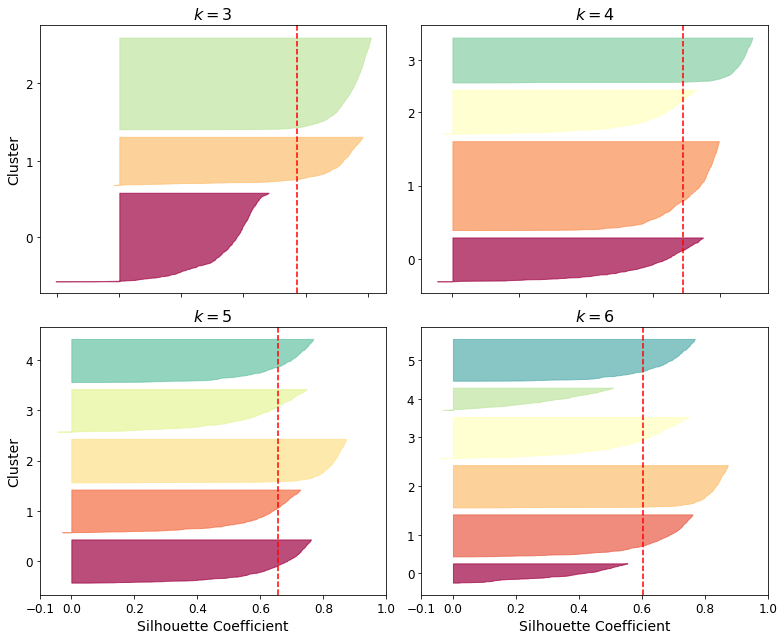

In [34]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

save_fig("silhouette_analysis_plot")
plt.show()

# 수직 점선: 각 클러스터 개수에 해당하는 실루엣 점수
# 칼날의 높이(세로): 클러스터가 포함하고 있는 샘플의 개수(k=4, index=1일 때 클러스터가 매우 큼)
# 칼날의 너비(가로): 이 클러스터에 포함된 샘플의 정렬된 실루엣 계수

# k=4일 때가 k=5일 때보다 전반적인 실루엣 점수가 높음.
# 하지만 비슷한 크기의 클러스터를 얻을 수 있는 k=5를 선택하는 것이 좋음

### 9.1.2 k-means의 한계

- 장점
    - 속도가 빠르고 확장이 용이
- 단점
    - 최적이 아닌 솔루션을 피하려면 알고리즘을 여러 번 실행해야 함
    - 클러스터 개수를 지정해야 함
    - 클러스터의 크기나 밀집도가 서로 다르거나 구형(spherical)이 아닐 경우 잘 작동하지 않음

#### k-means를 실행하기 전에 입력 특성의 스케일을 맞추는 것이 중요 -> 이렇게 하면 일반적으로 더 좋아짐

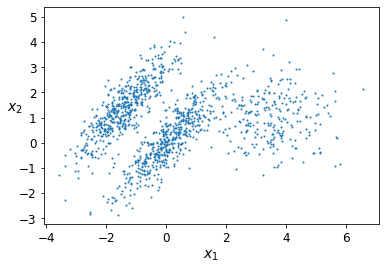

In [35]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

plot_clusters(X)

In [36]:
kmeans_good = KMeans(n_clusters=3, init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]), n_init=1, random_state=42)
kmeans_bad = KMeans(n_clusters=3, random_state=42)
kmeans_good.fit(X)
kmeans_bad.fit(X)

KMeans(n_clusters=3, random_state=42)

Saving figure bad_kmeans_plot


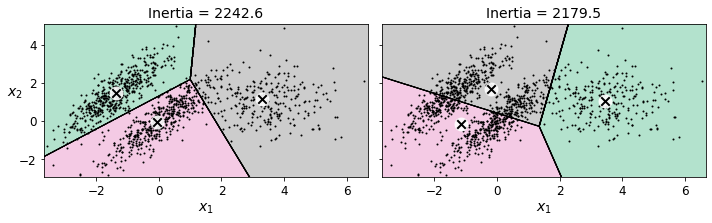

In [37]:
plt.figure(figsize=(10, 3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title("Inertia = {:.1f}".format(kmeans_good.inertia_), fontsize=14)

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title("Inertia = {:.1f}".format(kmeans_bad.inertia_), fontsize=14)

save_fig("bad_kmeans_plot")
plt.show()

# 방향이 다른 세 개의 타원형 클러스터를 가진 데이터 셋을 k-means로 군집해봄
# 왼쪽이 그나마 낫지만 가운데 클러스터의 오른쪽 위 부분이 오른쪽 클러스터로 할당됨
# 오른쪽은 끔찍

# 데이터에 따라서 잘 수행할 수 있는 군집 알고리즘이 다르다!!

### 9.1.3 군집을 사용한 이미지 분할(image segmentation)

- 이미지 분할: 이미지를 여러 개의 segment로 분할하는 작업
- 시맨틱 분할: 시맨틱 분할은 이미지의 모든 픽셀에 레이블 또는 카테고리를 연관 짓는 딥러닝 알고리즘
    - 예를 들어 자율 주행의 비전 시스템에서 보행자 이미지를 구성하는 모든 픽셀은 보행자 segment에 할당된 것임
    - 이 경우 각 보행자는 다른 세그먼트가 될 수 있음 -> 이런 분할을 인스턴스 분할이라고 함
    
#### 이런 분할에서 최고 수준의 성능을 내려면 합성곱 신경망을 사용한 복잡한 모델을 사용해야함

#### 여기서는 훨씬 쉬운 색상 분할을 수행해볼 것임 -> 동일한 색상을 가진 픽셀을 같은 세그먼트에 할당하기

In [38]:
import urllib.request

# Download the ladybug image
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "unsupervised_learning")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "ladybug.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/unsupervised_learning/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('./images/unsupervised_learning/ladybug.png',
 <http.client.HTTPMessage at 0x1299b3a00>)

In [39]:
from matplotlib.image import imread
image = imread(os.path.join(images_path, filename))
image.shape

# (높이, 너비, 컬러 채널(RGB) 개수)
# -> 800행 533열의 R채널, 800행 533열의 G채널, 800행 533열의 B채널

(533, 800, 3)

Text(0.5, 1.0, 'B channel')

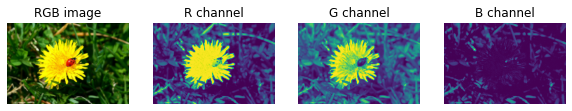

In [40]:
plt.figure(figsize=(10, 2))

plt.subplot(141)
plt.imshow(image[:, :, :])
plt.axis("off")
plt.title("RGB image")

plt.subplot(142)
plt.imshow(image[:, :, 0])
plt.axis("off")
plt.title("R channel")

plt.subplot(143)
plt.imshow(image[:, :, 1])
plt.axis("off")
plt.title("G channel")

plt.subplot(144)
plt.imshow(image[:, :, 2])
plt.axis("off")
plt.title("B channel")

In [41]:
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8, random_state=42).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

In [42]:
X.shape
# 각 컬러 채널의 800행 533열을 펼쳐서 R, G, B 각 색상의 긴 리스트로 변환한 것임

(426400, 3)

In [43]:
533*800

426400

In [44]:
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

Saving figure image_segmentation_diagram


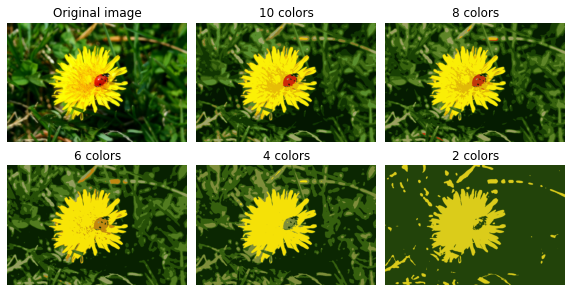

In [45]:
plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{} colors".format(n_clusters))
    plt.axis('off')

save_fig('image_segmentation_diagram', tight_layout=False)
plt.show()

# 1. 각 픽셀의 컬러 클러스터의 평균 컬러를 찾음
# 2. 각 픽셀을 속한 클러스터의  평균 컬로로 바꿈
# 3. 긴 색상 리스트를 다시 원본 이미지와 동일한 크기로 바꿈

# k가 8보다 작으면 무당벌레의 빨간색이 독자적인 클러스터를 만들지 못하고 주위 색에 합쳐짐
# k-means가 비슷한 크기의 클러스터를 만드는 경향이 있기 때문임

### 9.1.4 군집을 사용한 전처리

군집은 지도 학습 알고리즘을 적용하기 전에 전처리 단계로 사용할 수 있음

In [47]:
from sklearn.datasets import load_digits

In [48]:
X_digits, y_digits = load_digits(return_X_y=True)

In [60]:
X_digits.shape

(1797, 64)

In [49]:
from sklearn.model_selection import train_test_split

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)

In [51]:
from sklearn.linear_model import LogisticRegression

In [53]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [54]:
log_reg.score(X_test, y_test)

0.9688888888888889

In [58]:
# k-means로 전처리 해보기

from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('kmeans', KMeans(n_clusters=50)),
    # 숫자가 10개임. 하지만 숫자를 쓴 방식이 저마다 다르기 때문에 클러스터 개수를 더 크게 함
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)),
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('kmeans', KMeans(n_clusters=50)),
                ('log_reg',
                 LogisticRegression(max_iter=5000, multi_class='ovr',
                                    random_state=42))])

In [59]:
pipeline_score = pipeline.score(X_test, y_test)
pipeline_score

# 성능 향상 -> k-means로 변환된 데이터 셋이 원본보다 선형적으로 더 잘 구분할 수 있구나

0.9777777777777777

In [69]:
# 제일 좋은 k값 찾기

from sklearn.model_selection import GridSearchCV

param_grid = dict(kmeans__n_clusters=range(2, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 98 candidates, totalling 294 fits
[CV] END ...............................kmeans__n_clusters=2; total time=   0.3s
[CV] END ...............................kmeans__n_clusters=2; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=2; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.3s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.3s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=5; total time=   0.4s
[CV] END ...............................kmeans__n_clusters=5; total time=   0.2s
[CV] END ...............................kmeans_

[CV] END ..............................kmeans__n_clusters=35; total time=   4.1s
[CV] END ..............................kmeans__n_clusters=36; total time=   5.7s
[CV] END ..............................kmeans__n_clusters=36; total time=   5.5s
[CV] END ..............................kmeans__n_clusters=36; total time=   4.5s
[CV] END ..............................kmeans__n_clusters=37; total time=   3.8s
[CV] END ..............................kmeans__n_clusters=37; total time=   4.2s
[CV] END ..............................kmeans__n_clusters=37; total time=   4.5s
[CV] END ..............................kmeans__n_clusters=38; total time=   6.9s
[CV] END ..............................kmeans__n_clusters=38; total time=   6.5s
[CV] END ..............................kmeans__n_clusters=38; total time=   3.9s
[CV] END ..............................kmeans__n_clusters=39; total time=   4.0s
[CV] END ..............................kmeans__n_clusters=39; total time=   5.1s
[CV] END ...................

[CV] END ..............................kmeans__n_clusters=69; total time=   6.0s
[CV] END ..............................kmeans__n_clusters=70; total time=   5.8s
[CV] END ..............................kmeans__n_clusters=70; total time=   5.8s
[CV] END ..............................kmeans__n_clusters=70; total time=   5.6s
[CV] END ..............................kmeans__n_clusters=71; total time=   5.1s
[CV] END ..............................kmeans__n_clusters=71; total time=   4.9s
[CV] END ..............................kmeans__n_clusters=71; total time=   5.2s
[CV] END ..............................kmeans__n_clusters=72; total time=   4.4s
[CV] END ..............................kmeans__n_clusters=72; total time=   5.5s
[CV] END ..............................kmeans__n_clusters=72; total time=   5.2s
[CV] END ..............................kmeans__n_clusters=73; total time=   5.3s
[CV] END ..............................kmeans__n_clusters=73; total time=   5.8s
[CV] END ...................

/Users/wonjunsik/opt/anaconda3/envs/tfecon/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..............................kmeans__n_clusters=84; total time=   5.7s
[CV] END ..............................kmeans__n_clusters=85; total time=   5.4s
[CV] END ..............................kmeans__n_clusters=85; total time=   4.9s
[CV] END ..............................kmeans__n_clusters=85; total time=   4.9s
[CV] END ..............................kmeans__n_clusters=86; total time=   4.8s
[CV] END ..............................kmeans__n_clusters=86; total time=   5.3s
[CV] END ..............................kmeans__n_clusters=86; total time=   7.7s
[CV] END ..............................kmeans__n_clusters=87; total time=   8.2s
[CV] END ..............................kmeans__n_clusters=87; total time=   8.0s
[CV] END ..............................kmeans__n_clusters=87; total time=   7.6s
[CV] END ..............................kmeans__n_clusters=88; total time=   5.1s
[CV] END ..............................kmeans__n_clusters=88; total time=   4.9s
[CV] END ...................

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kmeans', KMeans(n_clusters=50)),
                                       ('log_reg',
                                        LogisticRegression(max_iter=5000,
                                                           multi_class='ovr',
                                                           random_state=42))]),
             param_grid={'kmeans__n_clusters': range(2, 100)}, verbose=2)

In [70]:
grid_clf.best_params_

{'kmeans__n_clusters': 98}

In [71]:
grid_clf.score(X_test, y_test)

0.98

### 9.1.5 군집을 사용한 준지도 학습

- 준지도 학습: 레이블된 샘플이 적다면 군집을 수행하고 동일 클러스터에 있는 모든 샘플에 레이블 전파

In [73]:
# 숫자 데이터셋에서 레이블된 50개 샘플에 로지스틱 회귀 모델을 훈련해보기
n_labeled = 50

log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", random_state=42)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])
log_reg.score(X_test, y_test)

0.8333333333333334

In [74]:
# 위의 경우 정확도가 높지 않음 -> 개선해보자

k = 50

kmeans = KMeans(n_clusters=k, random_state=42) # 먼저 훈련 셋을 50개의 클러스터로 모으기
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0) # 그다음 각 클러스터에서 센트로이드에 가장 가까운 이미지를 찾기
X_representative_digits = X_train[representative_digit_idx] # 이런 이미지를 대표 이미지(representative image)라고 함

Saving figure representative_images_diagram


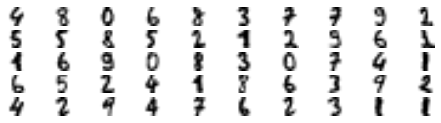

In [75]:
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')

save_fig("representative_images_diagram", tight_layout=False)
plt.show()

# 아래 이미지가 대표 이미지 50개임

In [76]:
y_train[representative_digit_idx]

array([4, 8, 0, 6, 8, 3, 7, 7, 9, 2, 5, 5, 8, 5, 2, 1, 2, 9, 6, 1, 1, 6,
       9, 0, 8, 3, 0, 7, 4, 1, 6, 5, 2, 4, 1, 8, 6, 3, 9, 2, 4, 2, 9, 4,
       7, 6, 2, 3, 1, 1])

In [77]:
# 수동으로 레이블 50개 할당해보기

y_representative_digits = np.array([4, 8, 0, 6, 8, 3, 7, 7, 9, 2, 5, 5, 8, 5, 2, 1, 2, 9, 6, 1, 1, 6,
       9, 0, 8, 3, 0, 7, 4, 1, 6, 5, 2, 4, 1, 8, 6, 3, 9, 2, 4, 2, 9, 4,
       7, 6, 2, 3, 1, 1])

In [78]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

# 레이블된 50개 샘플로 모델을 훈련했을 뿐인데 성능이 확 오름
# 샘플에 레이블을 부여하는 것은 비용이 많이 들고 어려움(특히 전문가가 수동으로 처리해야 할 때)
# 따라서 무작위 샘플 대신 대표 샘플에 레이블을 할당하는 것이 좋은 방법임

0.9222222222222223

In [80]:
# 위 방법에서 한 단계 더 나아가기
# 레이블을 동일한 클러스터에 있는 모든 샘플로 전파해보기(레이블 전파, label propagation)

y_train_propagated = np.empty(len(X_train), dtype=np.int32) # np.empty(): 초기화되지 않은 값으로 배열을 생성해줌
for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i] # i 클러스터의 값들(True)이 대표 이미지 값으로 싹 바뀌겠지

In [100]:
a = np.array([1,2,3])
print(a)

[1 2 3]


In [99]:
a[a==1] = 3 # True일 때 3으로 바뀌겠지
print(a)

[3 2 3]


In [101]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train_propagated)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [102]:
log_reg.score(X_test, y_test) # 성능 조금 더 향상됨

0.9333333333333333

In [103]:
# 더 생각해보기
# 위에서는 각 대표 샘플의 레이블을 동일한 클러스터의 모든 샘플에 전파함
# 여기에는 클러스터 경계에 가깝게 위치한 샘플이 포함되어 있고 이들은 레이블이 잘못 부여되어 있을 수 있음
# 센트로이드와 가까운 샘플의 20%에만 레이블을 전파해보자

percentile_closest = 20

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

In [104]:
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [105]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [106]:
log_reg.score(X_test, y_test)
# 레이블된 샘플 50개만 가지고 94%의 정확도를 얻었음
# -> 이는 레이블된 전체 데이터셋에서 훈련한 로지스틱 회귀 성능과 매우 가깝!
# -> 전파된 레이블이 매우 좋았구나

0.94

In [107]:
# 약 99% 실제 데이터와 같음
np.mean(y_train_partially_propagated == y_train[partially_propagated])

0.9896907216494846

### 능동 학습(active learning): 전문가가 학습 알고리즘과 상호작용하여 알고리즘이 요청할 때 특정 샘플의 레이블을 제공하는 것

#### 불확실성 샘플링이 널리 사용됨
1. 지금까지 수집한 레이블된 샘플에서 모델을 훈련 -> 이 모델을 이용해 레이블되지 않은 모든 샘플에 대한 예측을 만듦
2. 모델이 가장 불확실하게 예측한 샘플을 전문가에게 보내 레이블을 붙임
3. 레이블을 부여하는 노력만큼의 성능 향상이 없을 때까지 반복

### 9.1.6 DBSCAN(Density Based Spatial Clustering of Applications with Noise)

이 알고리즘은 밀집된 연속적 지역을 클러스터로 지정함

- 알고리즘이 각 샘플에서 작은 거리인 ε 내에 샘플이 몇 개 놓여 있는지 셈. 이 지역을 샘플의 ε-이웃이라고 함.
- 자기 자신을 포함해 ε-이웃 내에 적어도 min_samples개의 샘플이 있다면 이를 핵심 샘플로 간주함. 즉 핵심 샘플은 밀집된 지역에 있는 샘플임
- 핵심 샘플의 이웃에 있는 모든 샘플은 동일한 클러스터에 속함. 이웃에는 다른 핵심 샘플이 포함될 수 있음. 따라서 핵심 샘플의 이웃의 이웃은 계속해서 하나의 클러스터를 형성함.
- 핵심 샘플이 아니고 이웃도 아닌 샘플은 이상치로 판단함.

In [108]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)
dbscan = DBSCAN(eps=0.05, min_samples=5) # eps(epsilon)
# 핵심 샘플: eps 거리 안에 데이터가 지정한 min_samples 개수를 만족시키는 밀집 지역에 있는 데이터 포인트
dbscan.fit(X)

DBSCAN(eps=0.05)

In [111]:
dbscan.labels_ # -1은 이상치

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5,  2,  3,  0,  2,  2,  2,  4,
        2,  2,  4,  0,  5,  1,  0,  5,  5,  3,  2,  2,  2,  4,  5,  0,  6,
        1, -1,  0,  0,  2,  3, -1,  3,  4, -1,  4,  4,  2,  0,  6,  2,  0,
        2,  4,  0,  3,  3,  0,  3,  5,  2, -1,  3,  0,  5,  0,  0,  0,  2,
        3,  0,  3,  6,  0,  2,  4,  4,  0,  3,  0,  4,  0,  3, -1,  3,  4,
        0, -1,  2,  2,  4,  1,  6,  0,  5,  2,  6,  2,  3,  3, -1,  2, -1,
        2,  4,  0,  0,  0,  2,  5,  2,  0,  2, -1,  2,  3,  1,  5,  2,  0,
        4,  2,  1,  2,  4,  4,  0,  0,  6,  2,  2,  0,  2, -1,  2,  0,  3,
        3,  5, -1,  3,  3,  5,  2,  4,  2,  2,  2,  4,  2,  4,  0, -1,  2,
        1,  2,  6,  4,  2,  3,  2, -1,  2,  0,  0,  2,  0,  4,  0,  4,  4,
        1,  6,  3,  2,  6,  1,  4,  4,  2,  0,  6,  0,  1,  0,  2,  5,  1,
        1,  2,  2,  2,  2,  0,  5,  5,  1,  4,  5,  0,  3,  3,  0,  0,  0,
        2,  0,  5,  2, -1,  2,  3,  5,  2,  2,  0,  4,  0,  4,  2,  2,  4,
        2,  2,  3,  2,  3

In [120]:
len(dbscan.labels_[dbscan.labels_ == -1]) # 이상치 수

77

In [124]:
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6])

In [121]:
len(dbscan.core_sample_indices_) # core_sample_indices_: 핵심 샘플의 인스턴스 변수

808

In [122]:
dbscan.core_sample_indices_

array([  0,   4,   5,   6,   7,   8,  10,  11,  12,  13,  14,  16,  17,
        18,  19,  20,  21,  22,  23,  24,  25,  26,  28,  29,  30,  31,
        32,  33,  34,  36,  38,  39,  41,  42,  44,  45,  47,  49,  50,
        51,  52,  53,  54,  55,  56,  58,  59,  61,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  83,  84,  85,  87,  88,  89,  90,  91,  93,  94,  96,
        97,  98, 102, 103, 104, 105, 106, 107, 108, 109, 110, 113, 114,
       115, 116, 117, 119, 120, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 135, 136, 139, 140, 141, 143, 144, 145, 146, 147, 148, 149,
       150, 152, 153, 154, 155, 156, 157, 158, 159, 161, 162, 163, 164,
       165, 166, 167, 168, 169, 170, 172, 173, 174, 175, 176, 177, 178,
       179, 181, 182, 183, 185, 186, 187, 188, 189, 191, 193, 194, 195,
       196, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 209, 210,
       211, 212, 213, 214, 215, 216, 217, 218, 219, 221, 222, 22

In [123]:
dbscan.components_ # components_: 핵심 샘플 자체

array([[-0.02137124,  0.40618608],
       [-0.84192557,  0.53058695],
       [ 0.58930337, -0.32137599],
       ...,
       [ 1.66258462, -0.3079193 ],
       [-0.94355873,  0.3278936 ],
       [ 0.79419406,  0.60777171]])

In [125]:
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

DBSCAN(eps=0.2)

In [126]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

Saving figure dbscan_plot


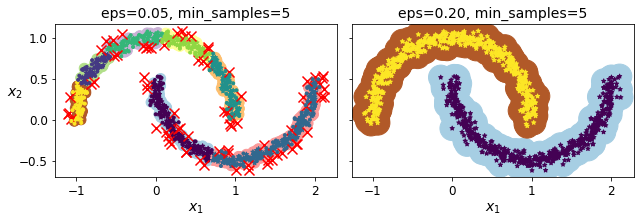

In [127]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

save_fig("dbscan_plot")
plt.show()

# 왼쪽 그림: 클러스터를 8개 만듦(빨간색 X 표시: 이상치임)
# 오른쪽 그림: eps를 증가시켰더니 완벽한 군집을 얻음

#### DBSCAN 클래스는 predict()를 제공하지 않고 fit_predict()를 제공함

DBSCAN은 새로운 데이터에 대해 예측할 수 없음!! -> 할거면 새로운 데이터를 추가해서 다시 DBSCAN을 훈련해야 함

fit_predict()는 단순히 fit()을 호출한 후 labels_ 인스턴스 변수를 반환하는 메서드임

따라서 사용자가 필요한 예측기를 선택해야 함

In [128]:
# KNeighborsClassifier를 훈련해보기

from sklearn.neighbors import KNeighborsClassifier

dbscan = dbscan2

knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(n_neighbors=50)

In [129]:
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]]) # 새로운 샘플
knn.predict(X_new) # 새로운 샘플이 어디 클러스터에 속할 가능성이 높을까?

array([1, 0, 1, 0])

In [130]:
knn.predict_proba(X_new) # 각 클러스터에 속할 확률

array([[0.18, 0.82],
       [1.  , 0.  ],
       [0.12, 0.88],
       [1.  , 0.  ]])

Saving figure cluster_classification_plot


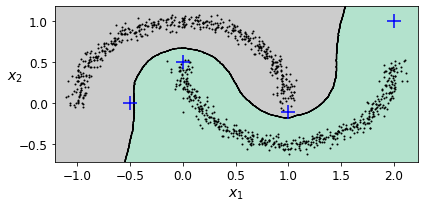

In [131]:
plt.figure(figsize=(6, 3))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="b", marker="+", s=200, zorder=10)
save_fig("cluster_classification_plot")
plt.show()

In [133]:
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1 # 이웃과의 거리가 0.2보다 큰 경우 이상치로 분류
y_pred.ravel()

array([-1,  0,  1, -1])

## 9.2 가우시안 혼합(Gaussian mixture)

샘플이 파라미터가 알려지지 않은 여러 개의 혼합된 가우시안 분포에서 생성되었다고 가정하는 확률 모델

In [134]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

In [135]:
from sklearn.mixture import GaussianMixture

In [136]:
gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
# n_components = 가우시안 분포의 수, n_init = 초기화 수
gm.fit(X)

GaussianMixture(n_components=3, n_init=10, random_state=42)

In [137]:
gm.weights_ # 각 분포의 가중치(9.1.2의 데이터 사용 -> 원형 클러스터의 데이터 250개, 왼쪽 타원형 클러스터 2개의 데이터는 각각 500개)
# 따라서 가중치가 0.2, 0.4, 0.4

array([0.39025715, 0.40007391, 0.20966893])

In [139]:
gm.means_ # 특성이 2개이므로 평균이 특성마다 하나씩 반환됨

array([[ 0.05131611,  0.07521837],
       [-1.40763156,  1.42708225],
       [ 3.39893794,  1.05928897]])

In [140]:
gm.covariances_

array([[[ 0.68799922,  0.79606357],
        [ 0.79606357,  1.21236106]],

       [[ 0.63479409,  0.72970799],
        [ 0.72970799,  1.1610351 ]],

       [[ 1.14833585, -0.03256179],
        [-0.03256179,  0.95490931]]])

#### 어떻게 이런 결과값들이 나왔을까? -> 기댓값-최대화(EM, expectation-maximization) 알고리즘

1. 샘플을 클러스터에 할당(기댓값 단계)
2. 클러스터를 업데이트(최대화 단계)
3. 수렴할 때까지 반복

- EM은 소프트 클러스터 할당 사용
    - 예를 들어 기댓값 단계에서 알고리즘은 현재 클러스터 파라미터에 기반하여 각 클러스터에 속할 확률을 예측함
    - 그다음 최대화 단계에서 각 클러스터가 데이터셋에 있는 모든 샘플을 사용해 업데이트됨
    - 클러스터에 속할 추정 확률로 샘플에 가중치가 적용됨 -> 이 확률을 샘플에 대한 클러스터의 `책임(responsibility)`이라고 함
    - 최대화 단계에서 클러스터 업데이트는 책임이 가장 많은 샘플에 크게 영향을 받음

In [141]:
gm.converged_ # 알고리즘이 수렴했니?

True

In [142]:
gm.n_iter_ # 알고리즘의 반복 횟수

4

In [143]:
gm.predict(X) # gm모델을 통해 새로운 샘플을 가장 비슷한 클러스터에 할당(하드 군집)

array([0, 0, 1, ..., 2, 2, 2])

In [144]:
gm.predict_proba(X) # gm모델을 통해 특정 클러스터에 속할 확률을 예측(소프트 군집)

array([[9.76741808e-01, 6.78581203e-07, 2.32575136e-02],
       [9.82832955e-01, 6.76173663e-04, 1.64908714e-02],
       [7.46494398e-05, 9.99923327e-01, 2.02398402e-06],
       ...,
       [4.26050456e-07, 2.15512941e-26, 9.99999574e-01],
       [5.04987704e-16, 1.48083217e-41, 1.00000000e+00],
       [2.24602826e-15, 8.11457779e-41, 1.00000000e+00]])

#### 가우시안 혼합 모델은 생성 모델임
- 생성 모델: 생성 모델(generative model)은 주어진 데이터를 학습하여 데이터 분포를 따르는 유사한 데이터를 생성하는 모델

In [145]:
X_new, y_new = gm.sample(6)
X_new

array([[-0.86944074, -0.32767626],
       [ 0.29836051,  0.28297011],
       [-2.8014927 , -0.09047309],
       [ 3.98203732,  1.49951491],
       [ 3.81677148,  0.53095244],
       [ 2.84104923, -0.73858639]])

In [146]:
y_new

array([0, 0, 1, 2, 2, 2])

In [147]:
gm.score_samples(X) # 주어진 위치에서 모델의 밀도를 추정할 수 있음 -> 샘플이 주어지면 그 위치의 확률 밀도 함수의 로그를 예측함
# 점수가 높을수록 밀도가 높음

# 이 점수의 지숫값을 계산하면 샘플의 위치에서 PDF 값을 얻을 수 있음
# 이 값은 하나의 확률 변수가 아니라 확률 밀도임
# 샘플이 특정 지역 안에 속할 확률을 예측하려면 그 지역에 대해 PDF를 적분해야 함

array([-2.60768954, -3.57110232, -3.32987086, ..., -3.51347241,
       -4.39798588, -3.80746532])

In [148]:
resolution = 100
grid = np.arange(-10, 10, 1 / resolution)
xx, yy = np.meshgrid(grid, grid)
X_full = np.vstack([xx.ravel(), yy.ravel()]).T

pdf = np.exp(gm.score_samples(X_full))
pdf_probas = pdf * (1 / resolution) ** 2
pdf_probas.sum()

0.9999999999215021

In [149]:
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

Saving figure gaussian_mixtures_plot


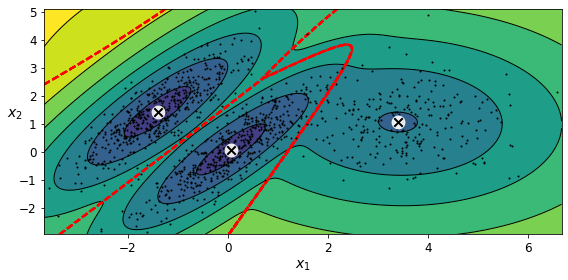

In [150]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)

save_fig("gaussian_mixtures_plot")
plt.show()

# 아래 그림은 이 모델의 클러스터 평균, 결정 경계(파선), 밀도 등고선을 보여줌

특성이나 클러스터가 많거나 샘플이 적을 때는 EM이 최적의 솔루션으로 수렴하기 어려움

이런 작업의 어려움을 줄이려면 알고리즘이 학습할 파라미터 개수를 제한해야 함

이런 방법 중 하나는 클러스터의 모양과 방향의 범위를 제한하는 것

#### 공분산 행렬에 제약을 추가하여 할 수 있음(covariance_type=)
- 'spherical': 모든 클러스터가 원형(지름은 다를 수 있음. 즉 분산이 다를 수 있음)
- 'diag': 클러스터는 크기에 상관없이 어떤 타원형도 가능. 하지만 타원의 축은 좌표 축과 나란해야 함(즉 공분산 행렬이 대각 행렬이어야 함)
- 'tied': 모든 클러스터가 동일한 타원 모양, 크기, 방향을 가짐(즉 모든 클러스터는 동일한 공분산 행렬을 공유함)

In [151]:
gm_full = GaussianMixture(n_components=3, n_init=10, covariance_type="full", random_state=42)
gm_tied = GaussianMixture(n_components=3, n_init=10, covariance_type="tied", random_state=42)
gm_spherical = GaussianMixture(n_components=3, n_init=10, covariance_type="spherical", random_state=42)
gm_diag = GaussianMixture(n_components=3, n_init=10, covariance_type="diag", random_state=42)
gm_full.fit(X)
gm_tied.fit(X)
gm_spherical.fit(X)
gm_diag.fit(X)

GaussianMixture(covariance_type='diag', n_components=3, n_init=10,
                random_state=42)

In [152]:
def compare_gaussian_mixtures(gm1, gm2, X):
    plt.figure(figsize=(9, 4))

    plt.subplot(121)
    plot_gaussian_mixture(gm1, X)
    plt.title('covariance_type="{}"'.format(gm1.covariance_type), fontsize=14)

    plt.subplot(122)
    plot_gaussian_mixture(gm2, X, show_ylabels=False)
    plt.title('covariance_type="{}"'.format(gm2.covariance_type), fontsize=14)

Saving figure covariance_type_plot


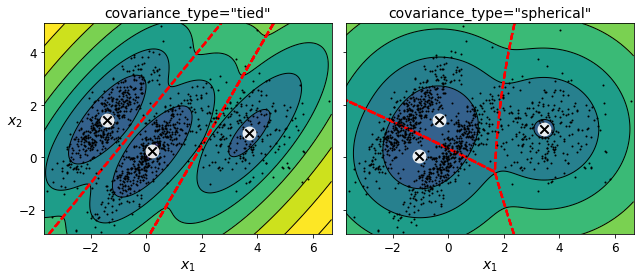

In [153]:
compare_gaussian_mixtures(gm_tied, gm_spherical, X)

save_fig("covariance_type_plot")
plt.show()

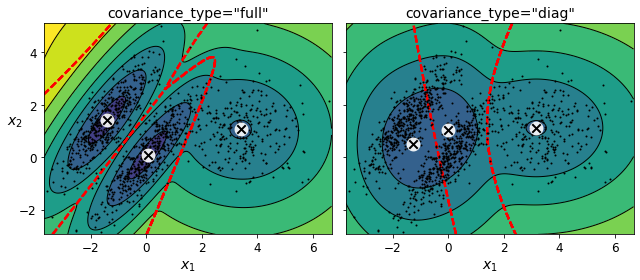

In [154]:
compare_gaussian_mixtures(gm_full, gm_diag, X)
plt.tight_layout()
plt.show()

### 9.2.1 가우시안 혼합을 사용한 이상치 탐지

밀도가 낮은 지역에 있는 샘플을 이상치로 볼 수 있음 -> 이를 위해서는 밀도 임곗값을 정해야 함

In [155]:
# 4%를 밀도 임곗값으로 사용하여 이상치를 구분하기

densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 4)
anomalies = X[densities < density_threshold]

Saving figure mixture_anomaly_detection_plot


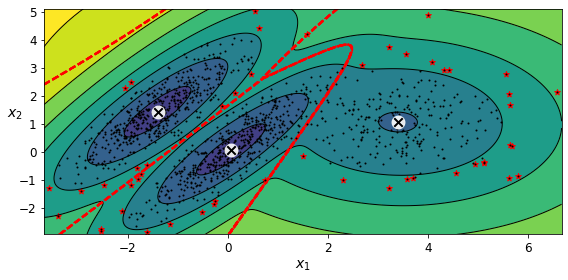

In [156]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)

save_fig("mixture_anomaly_detection_plot")
plt.show()

# 별 모양이 이상치

### 9.2.2 클러스터 개수 선택하기

k-means에서는 inertia나 실루엣 점수를 사용해 적절한 클러스터 개수를 선택

가우시안 혼합에서는 이런 지표를 사용할 수 없음. 이런 지표들은 클러스터가 타원형이거나 크기가 다를 때 안정적이지 않기 때문

대신 BIC(Bayesian information criterion)나 AIC(Akaike information criterion)와 같은 이론적 정보 기준(theoretical information criterion)을 최소화하는 모델을 찾음

$$ BIC = log(m)p - 2log(\hat{L}) $$
$$ AIC = 2p - 2log(\hat{L}) $$
- m = 샘플의 개수
- p = 모델이 학습할 파라미터 개수
- $\hat{L}$ = 모델의 가능도 함수(likelihood function)의 최댓값

BIC와 AIC는 모두 학습할 파라미터가 많은(즉 클러스터가 많은) 모델에게 벌칙을 가하고 데이터에 잘 학습하는 모델에게 보상을 더함

둘이 서로 다른 모델을 선택할 경우 BIC가 선택한 모델이 AIC가 선택한 모델보다 간단한(파라미터가 적은) 경향이 있음. 하지만 데이터에 아주 잘 맞지 않을 수 있음(특히 대규모 데이터셋에서 그러함)

In [157]:
gm.bic(X)

8189.747000497186

In [158]:
gm.aic(X)

8102.521720382148

In [159]:
# 수동으로 BIC, AIC 계산해보기

n_clusters = 3
n_dims = 2
n_params_for_weights = n_clusters - 1
n_params_for_means = n_clusters * n_dims
n_params_for_covariance = n_clusters * n_dims * (n_dims + 1) // 2
n_params = n_params_for_weights + n_params_for_means + n_params_for_covariance
max_log_likelihood = gm.score(X) * len(X) # log(L^)
bic = np.log(len(X)) * n_params - 2 * max_log_likelihood
aic = 2 * n_params - 2 * max_log_likelihood

In [160]:
bic, aic

(8189.747000497186, 8102.521720382148)

In [161]:
n_params

17

Saving figure aic_bic_vs_k_plot


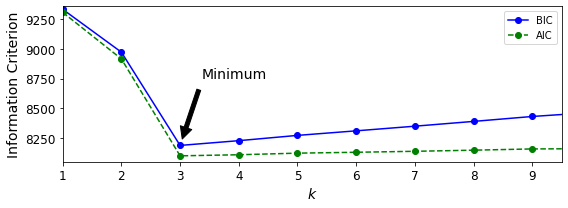

In [162]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
             for k in range(1, 11)]

bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 50])
plt.annotate('Minimum',
             xy=(3, bics[2]),
             xytext=(0.35, 0.6),
             textcoords='figure fraction',
             fontsize=14,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.legend()
save_fig("aic_bic_vs_k_plot")
plt.show()

# k에 따른 BIC와 AIC -> k=3이 최선의 선택으로 보임
# covariance_type에 대해 최선의 선택을 탐색할 수도 있겠지

### 9.2.3 베이즈 가우시안 혼합 모델

-> 최적의 클러스터 개수를 수동으로 찾지 않고 불필요한 클러스터의 가중치를 0에 가깝게 만듦

이 모델에서는 클러스터 파라미터(가중치, 평균, 공분산 행렬 등)는 더이상 고정된 모델 파라미터가 아니라 클러스터 할당처럼 `잠재 확률 변수로 취급됨`
- 잠재 변수(latent variable)는 구성개념(Construct)이 직접적으로 관찰되거나 측정이 되지 않는 변수를 의미한다.
- 구성개념은 과학적 연구방법이나 논리적인 이론에 근거하여 이를 설명하기 위하여 조작적으로 만들어 낸 개념을 지칭한다. 직접 측정할 수는 없으나 측정할 수 있는 현상을 유발한다고 가정한다. 이러한 구성개념에는 의식, 욕구, 지각, 자아, 동기 따위의 개념이 있다.

잠재 변수 $z$에 대한 사전 지식 -> `사전 확률(prior)`이라는 확률 분포 $p(z)$에 인코딩될 수 있음 -> 예를 들어 클러스터 개수가 적을까? 많을까? 같은 사전 믿음은 weight_concentration_prior 매개변수를 사용해 조정할 수 있음(사실 데이터가 많을수록 사전 믿음은 중요하지 않음)

---

베이즈 정리는 데이터 X를 관측하고 난 후 잠재 변수에 대한 확률 분포를 업데이트하는 방법을 설명함 -> 이는 X가 주어졌을 때 z의 조건부 확률인 `사후 확률(posterior) 분포` $p(z|X)$를 계산함
$$ p(z|X) = 사후 확률 = \frac{가능도*사전 확률}{증거} = \frac{p(X|z)p(z)}{p(X)} $$
위 식에서 분모 $p(X)$는 계산하기 힘듦 -> 가능한 모든 z값에 대해 적분해야 하기 때문
$$ p(X) = \int{p(X|z)p(z)dz} $$
이것이 베이즈 통계학에 있는 주요 문제 -> 이를 해결하기 위한 방법 중 하나가 변분 추론(variational inference)

In [163]:
# 클러스터 개수 n_components를 최적의 클러스터 개수보다 크다고 믿을 만한 값으로 지정
# (현재 문제에 대해 최소한의 정보를 가지고 있다고 가정하고)
# 이 알고리즘은 자동으로 불필요한 클러스터를 제거함

from sklearn.mixture import BayesianGaussianMixture

bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X)

BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)

In [164]:
np.round(bgm.weights_, 2) # 3개의 클러스터가 필요하다는 것을 감지함

array([0.4 , 0.21, 0.4 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

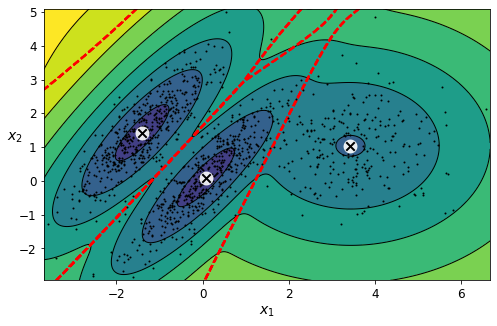

In [165]:
plt.figure(figsize=(8, 5))
plot_gaussian_mixture(bgm, X)
plt.show()

In [166]:
bgm_low = BayesianGaussianMixture(n_components=10, max_iter=1000, n_init=1,
                                  weight_concentration_prior=0.01, random_state=42)
bgm_high = BayesianGaussianMixture(n_components=10, max_iter=1000, n_init=1,
                                  weight_concentration_prior=10000, random_state=42)
nn = 73
bgm_low.fit(X[:nn])
bgm_high.fit(X[:nn])

BayesianGaussianMixture(max_iter=1000, n_components=10, random_state=42,
                        weight_concentration_prior=10000)

In [167]:
np.round(bgm_low.weights_, 2)

array([0.52, 0.48, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

In [168]:
np.round(bgm_high.weights_, 2)

array([0.01, 0.18, 0.27, 0.11, 0.01, 0.01, 0.01, 0.01, 0.37, 0.01])

Saving figure mixture_concentration_prior_plot


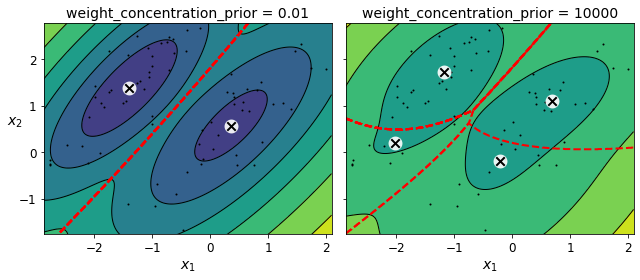

In [169]:
plt.figure(figsize=(9, 4))

plt.subplot(121)
plot_gaussian_mixture(bgm_low, X[:nn])
plt.title("weight_concentration_prior = 0.01", fontsize=14)

plt.subplot(122)
plot_gaussian_mixture(bgm_high, X[:nn], show_ylabels=False)
plt.title("weight_concentration_prior = 10000", fontsize=14)

save_fig("mixture_concentration_prior_plot")
plt.show()

# 클러스터 개수에 대한 사전 믿음에 따른 그래프(데이터가 적어서 그래프간의 차이가 큼)

In [170]:
X_moons, y_moons = make_moons(n_samples=1000, noise=0.05, random_state=42)

In [171]:
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X_moons)

BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)

Saving figure moons_vs_bgm_plot


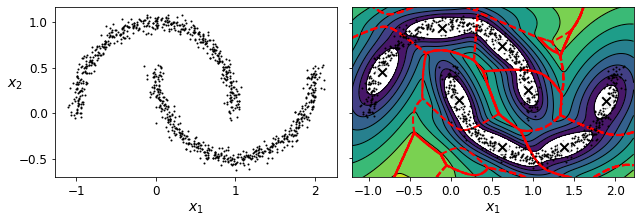

In [172]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_data(X_moons)
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14, rotation=0)

plt.subplot(122)
plot_gaussian_mixture(bgm, X_moons, show_ylabels=False)

save_fig("moons_vs_bgm_plot")
plt.show()

# 가우시안 혼합 모델은 타원형 클러스터에 잘 작동함. 하지만 다른 모양을 가진 데이터셋에 훈련하면 나쁜 결과를 얻게 될 것

In [173]:
from scipy.stats import norm

In [174]:
xx = np.linspace(-6, 4, 101)
ss = np.linspace(1, 2, 101)
XX, SS = np.meshgrid(xx, ss)
ZZ = 2 * norm.pdf(XX - 1.0, 0, SS) + norm.pdf(XX + 4.0, 0, SS)
ZZ = ZZ / ZZ.sum(axis=1)[:,np.newaxis] / (xx[1] - xx[0])

Saving figure likelihood_function_plot


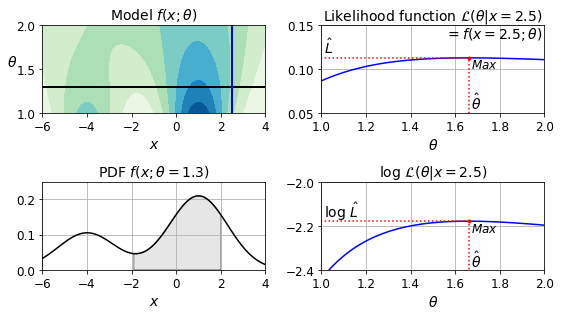

In [175]:
from matplotlib.patches import Polygon

plt.figure(figsize=(8, 4.5))

x_idx = 85
s_idx = 30

plt.subplot(221)
plt.contourf(XX, SS, ZZ, cmap="GnBu")
plt.plot([-6, 4], [ss[s_idx], ss[s_idx]], "k-", linewidth=2)
plt.plot([xx[x_idx], xx[x_idx]], [1, 2], "b-", linewidth=2)
plt.xlabel(r"$x$")
plt.ylabel(r"$\theta$", fontsize=14, rotation=0)
plt.title(r"Model $f(x; \theta)$", fontsize=14)

plt.subplot(222)
plt.plot(ss, ZZ[:, x_idx], "b-")
max_idx = np.argmax(ZZ[:, x_idx])
max_val = np.max(ZZ[:, x_idx])
plt.plot(ss[max_idx], max_val, "r.")
plt.plot([ss[max_idx], ss[max_idx]], [0, max_val], "r:")
plt.plot([0, ss[max_idx]], [max_val, max_val], "r:")
plt.text(1.01, max_val + 0.005, r"$\hat{L}$", fontsize=14)
plt.text(ss[max_idx]+ 0.01, 0.055, r"$\hat{\theta}$", fontsize=14)
plt.text(ss[max_idx]+ 0.01, max_val - 0.012, r"$Max$", fontsize=12)
plt.axis([1, 2, 0.05, 0.15])
plt.xlabel(r"$\theta$", fontsize=14)
plt.grid(True)
plt.text(1.99, 0.135, r"$=f(x=2.5; \theta)$", fontsize=14, ha="right")
plt.title(r"Likelihood function $\mathcal{L}(\theta|x=2.5)$", fontsize=14)

plt.subplot(223)
plt.plot(xx, ZZ[s_idx], "k-")
plt.axis([-6, 4, 0, 0.25])
plt.xlabel(r"$x$", fontsize=14)
plt.grid(True)
plt.title(r"PDF $f(x; \theta=1.3)$", fontsize=14)
verts = [(xx[41], 0)] + list(zip(xx[41:81], ZZ[s_idx, 41:81])) + [(xx[80], 0)]
poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
plt.gca().add_patch(poly)

plt.subplot(224)
plt.plot(ss, np.log(ZZ[:, x_idx]), "b-")
max_idx = np.argmax(np.log(ZZ[:, x_idx]))
max_val = np.max(np.log(ZZ[:, x_idx]))
plt.plot(ss[max_idx], max_val, "r.")
plt.plot([ss[max_idx], ss[max_idx]], [-5, max_val], "r:")
plt.plot([0, ss[max_idx]], [max_val, max_val], "r:")
plt.axis([1, 2, -2.4, -2])
plt.xlabel(r"$\theta$", fontsize=14)
plt.text(ss[max_idx]+ 0.01, max_val - 0.05, r"$Max$", fontsize=12)
plt.text(ss[max_idx]+ 0.01, -2.39, r"$\hat{\theta}$", fontsize=14)
plt.text(1.01, max_val + 0.02, r"$\log \, \hat{L}$", fontsize=14)
plt.grid(True)
plt.title(r"$\log \, \mathcal{L}(\theta|x=2.5)$", fontsize=14)

save_fig("likelihood_function_plot")
plt.show()